# Demo of CP tensor decomposition on a synthetic neural data

This notebook creates a toy model dataset of neural population activity encoded as a `neurons x time x trial` tensor:

- `data[n, t, k]` provides the firing rate of neuron `n` at time `t` on trial `k`.
- `data[:, :, k]` provides the population activity of all neurons on trial `k`, encoded as a `neurons x time` matrix.
- `data[n, :, :]` provides the activity of neuron `n` across all trials.

### Background on CP Decomposition

The CP decomposition approximates the full data tensor as a sum of rank-1 tensors. Mathematically, let $\mathcal{X} \in \mathbb{R}^{N \times T \times K}$ be a third-order tensor containing a dataset of $N$ neurons, $T$ timepoints, and $K$ trials. Let $\mathbf{A} \in \mathbb{R}^{N \times R}$, $\mathbf{B} \in \mathbb{R}^{T \times R}$, and $\mathbf{C} \in \mathbb{R}^{K \times R}$ be low-rank factor matrices containing a low-dimensional factors for each mode of the tensor. Then a rank-$R$ CP decomposition approximates the data as $\hat{\mathcal{X}}$, defined by:

$$
\hat{\mathcal{X}} = \sum_{r=1}^R \mathbf{a}_{:r} \circ \mathbf{b}_{:r} \circ \mathbf{c}_{:r} \quad \iff \quad \hat{x}_{ntk} = \sum_{r=1}^R a_{nr} b_{tr} c_{kr} \, .
$$

The two equations listed above are equivalent definitions/perspectives of CP decomposition (the "$\circ$" symbol denotes the vector outer product). Now let's translate this math to Python. Given three factor matrices `A`, `B`, and `C` (numpy arrays), we can express the CP decomposition model as:

```python
# estimate of full data tensor
estimate = np.einsum('ir,jr,kr -> ijk', A, B, C)

# estimate of a single entry
estimate[n, t, k] = np.sum(A[n, :] * B[t, :] * C[k, :])
```

### Description of toy model data

We suppose there are two, decorrelated latent variables that either active or inactive on each trial. The first alternates between zero and one every other trial, and the second is zero for the first half of trials and one for the second half of trials. These could be thought of as two experimental conditions - e.g. the prescence or abscence of a sensory stimulus on each trial. This structure is encoded into the across-trial factor matrix $\mathbf{C}$.

The two latent stimuli drive overlapping populations of neurons at different time points within the trial. This structure is encoded into the neuron factor matrix $\mathbf{A}$ and the within-trial (i.e. time) factor matrix $\mathbf{B}$.

In [1]:
import numpy as np
np.random.seed(1234)
import matplotlib.pylab as plt
import tensortools as tt
%matplotlib inline

In [2]:
# dimensions & params
N = 50      # neurons
T = 60      # time points
K = 40      # trials
R = 2       # number of latent factors

### Generate latent factors for toy dataset

In [3]:
# true factors
lgc = lambda x: 1 / (1+np.exp((N/2-x)*0.2))
A = np.array(([lgc(n) for n in range(N)], [lgc(n) for n in range(N)[::-1]])).T
B = np.array(([np.exp(-(t-T/3)**2/100) for t in range(T)], [np.exp(-(t-2*T/3)**2/100) for t in range(T)])).T / 1.1
C = np.array(([k%2 for k in range(K)], [int(k>=K/2) for k in range(K)])).T

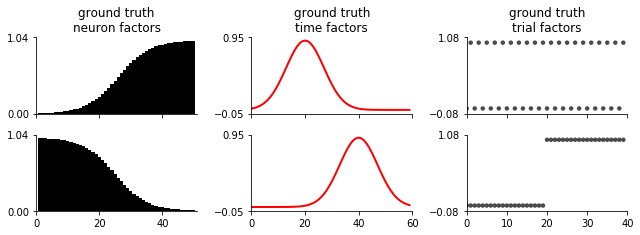

In [4]:
# neuron factor appearance
bar_kw = {
    'color': 'k',
    'width': 1
}
# temporal factor appearance
line_kw = {
    'color': 'r',
    'linewidth': 2
}
# temporal factor appearance
scatter_kw = {
    'color': 'k',
    'alpha': 0.7,
    's': 20
}

# make plots
kw = dict(figsize=(9,3), bar_kw=bar_kw, line_kw=line_kw, scatter_kw=scatter_kw)
fig, axes, pl = tt.plot_factors([A, B, C], plots=['bar', 'line', 'scatter'], **kw)

# titles
axes[0,0].set_title('ground truth\nneuron factors')
axes[0,1].set_title('ground truth\ntime factors')
axes[0,2].set_title('ground truth\ntrial factors')

## CP decomposition recovers true latent factors in a linear toy network (w/ noise)

In [5]:
# generate the toy dataset from latent factors
data = np.einsum('ir,jr,kr->ijk', A, B, C)

# add some noise
data += .1 * np.random.randn(N, T, K)

# start from randomized initial factors and optimize the CP decomposition
model, info = tt.cp_als(data, R, nonneg=True, tol=1e-5)
estimate = np.einsum('ir,jr,kr->ijk', *model)
print('Final reconstruction error : {}'.format(info['err_hist'][-1]))

converged in 4 iterations.Final reconstruction error : 0.3565264786100615


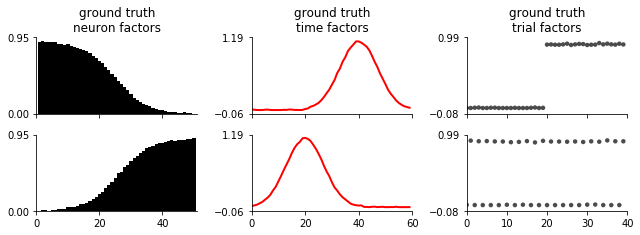

In [6]:
# make plots
kw = dict(figsize=(9,3), bar_kw=bar_kw, line_kw=line_kw, scatter_kw=scatter_kw)
fig, axes, pl = tt.plot_factors(model, plots=['bar', 'line', 'scatter'], **kw)

# titles
axes[0,0].set_title('ground truth\nneuron factors')
axes[0,1].set_title('ground truth\ntime factors')
axes[0,2].set_title('ground truth\ntrial factors')

### Example single cell and model reconstruction

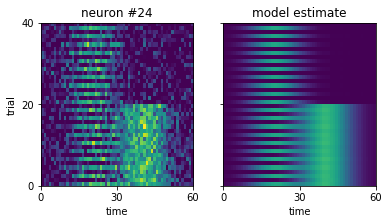

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(6,3), sharey=True)
neuron = 24
im_kw = {
    'cmap': 'viridis',
    'aspect': 'auto',
    'extent': [0,T,0,K],
    'clim': (0, .7)
}
axes[0].imshow(data[neuron].T, **im_kw)
axes[1].imshow(estimate[neuron].T, **im_kw)

for ax in axes:
    ax.set_yticks([0, K/2, K])
    ax.set_xticks([0, T/2, T])
    ax.set_xlabel('time')

axes[0].set_ylabel('trial')
axes[0].set_title('neuron #{}'.format(neuron))
axes[1].set_title('model estimate')

## Next Steps

Check out the [`classic-als`](./classic-als.ipynb) and [`nonneg-als`](./classic-als.ipynb) example notebooks for a demonstration of how to fit many models and assess how to choose the `# of components` in the model with a scree plot.